# Project: Investigate a European Soccer Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction: which player in European league showed the most improved performance throughout his career?

> The database I selected is a soccer database that comes from Kaggle. It contains data for soccer matches, players and teams from several European countries from 2008 to 2016. By means of Exploratory Data Analysis method, I would like to analyze which player in European league showed the most improved performance throughout his career. Also, I would like to find out how he's rating has been improved and how his team's standing in the league has changed throughout his career.

In [31]:
# Import necessary packages
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
% matplotlib inline


<a id='wrangling'></a>
## Data Wrangling

> In this section, I checked the dataset and trim unnecessary columns. Also, new column is appended in player attribute table for better analysis.

### Data Gathering

In [32]:
# Connect to the database and load all the tables on the python code
con = sqlite3.connect('database.sqlite')

country = pd.read_sql('SELECT * FROM Country', con)
league = pd.read_sql('SELECT * FROM League', con)
match = pd.read_sql('SELECT * FROM Match', con)
player = pd.read_sql('SELECT * FROM Player', con)
pa = pd.read_sql('SELECT * FROM Player_Attributes', con)
team = pd.read_sql('SELECT * FROM Team', con)
ta = pd.read_sql('SELECT * FROM Team_Attributes', con)

### Data Assessing

In [33]:
# 1-1. Very large columns on match table
match.shape

(25979, 115)

In [34]:
# 1-2. Lots of null values in match table
match.isnull().sum()

id                      0
country_id              0
league_id               0
season                  0
stage                   0
date                    0
match_api_id            0
home_team_api_id        0
away_team_api_id        0
home_team_goal          0
away_team_goal          0
home_player_X1       1821
home_player_X2       1821
home_player_X3       1832
home_player_X4       1832
home_player_X5       1832
home_player_X6       1832
home_player_X7       1832
home_player_X8       1832
home_player_X9       1832
home_player_X10      1832
home_player_X11      1832
away_player_X1       1832
away_player_X2       1832
away_player_X3       1832
away_player_X4       1832
away_player_X5       1832
away_player_X6       1832
away_player_X7       1832
away_player_X8       1832
                    ...  
B365H                3387
B365D                3387
B365A                3387
BWH                  3404
BWD                  3404
BWA                  3404
IWH                  3459
IWD         

In [35]:
# 2. The data type of 'date' in match, team_attribute and player_attribute table is object, not datetime.
match['date'].dtypes, ta['date'].dtypes, pa['date'].dtypes

(dtype('O'), dtype('O'), dtype('O'))

### Data Cleaning

In [36]:
# 1. Make new dataframe that does not contain columns that are not used in this notebook for analysis
match_simple = match.iloc[:, :11]
match_simple.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3


In [37]:
# 2. change data type of 'date' column to datetime
match_simple['date'] = pd.to_datetime(match_simple['date'])
pa['date'] = pd.to_datetime(pa['date'])
ta['date'] = pd.to_datetime(ta['date'])
player['birthday'] = pd.to_datetime(player['birthday'])
match_simple['date'].dtypes, ta['date'].dtypes, pa['date'].dtypes, player['birthday'].dtypes

(dtype('<M8[ns]'), dtype('<M8[ns]'), dtype('<M8[ns]'), dtype('<M8[ns]'))

In [38]:
# 3. From which month to which month means season 2012/2013?
for season in match_simple['season'].unique():
    min = match_simple.query('season == @season')['date'].min()
    max = match_simple.query('season == @season')['date'].max()
    print("<",season,">", "min: ",min, "   max: ",max)

< 2008/2009 > min:  2008-07-18 00:00:00    max:  2009-05-31 00:00:00
< 2009/2010 > min:  2009-07-11 00:00:00    max:  2010-05-16 00:00:00
< 2010/2011 > min:  2010-07-17 00:00:00    max:  2011-05-29 00:00:00
< 2011/2012 > min:  2011-07-16 00:00:00    max:  2012-05-23 00:00:00
< 2012/2013 > min:  2012-07-13 00:00:00    max:  2013-06-02 00:00:00
< 2013/2014 > min:  2013-07-13 00:00:00    max:  2014-05-18 00:00:00
< 2014/2015 > min:  2014-07-18 00:00:00    max:  2015-05-31 00:00:00
< 2015/2016 > min:  2015-07-17 00:00:00    max:  2016-05-25 00:00:00


> The result shows that the season starts in July and ends at least in June of the next year

In [39]:
# 4. Append 'season' column in team attributes and player attributes so that it is easier to compare them with match table
# 4-1. Define a function that decides the season according to a date.
def to_season (date):
    if date.month >= 7:
        return str(date.year)+"/"+str(date.year+1)
    else:
        return str(date.year-1)+"/"+str(date.year)
    
# test function
to_season(pd.to_datetime('2008-07-18')), to_season(pd.to_datetime('2010-05-16'))

('2008/2009', '2009/2010')

In [40]:
# 4-2. Append 'season' column in team attributes and player attributes
pa['season'] = pa['date'].apply(lambda t : to_season(t))

pa.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,season
0,1,218353,505942,2016-02-18,67.0,71.0,right,medium,medium,49.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2015/2016
1,2,218353,505942,2015-11-19,67.0,71.0,right,medium,medium,49.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2015/2016
2,3,218353,505942,2015-09-21,62.0,66.0,right,medium,medium,49.0,...,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,2015/2016
3,4,218353,505942,2015-03-20,61.0,65.0,right,medium,medium,48.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,2014/2015
4,5,218353,505942,2007-02-22,61.0,65.0,right,medium,medium,48.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,2006/2007


In [41]:
# 5. Merge player and player_attribute table for the better analysis
player_merge = player.merge(pa, left_on='player_api_id', right_on='player_api_id', how='inner')

player_merge.shape

(183978, 49)

<a id='eda'></a>
## Exploratory Data Analysis

### Q0. Basic information of players exploration (Single variable exploration)

In [42]:
# Extract birth year from birthday
player['birthyear'] = player['birthday'].apply(lambda t: t.year)

player[['birthyear', 'height', 'weight']].describe()

,birthyear,height,weight
count,11060.000000,11060.000000,11060.000000
mean,1986.642857,181.867445,168.380289
std,5.481362,6.369201,14.990217
min,1967.000000,157.480000,117.000000
25%,1983.000000,177.800000,159.000000
50%,1987.000000,182.880000,168.000000
75%,1991.000000,185.420000,179.000000
max,1999.000000,208.280000,243.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E053D15E10>,
      dtype=object)

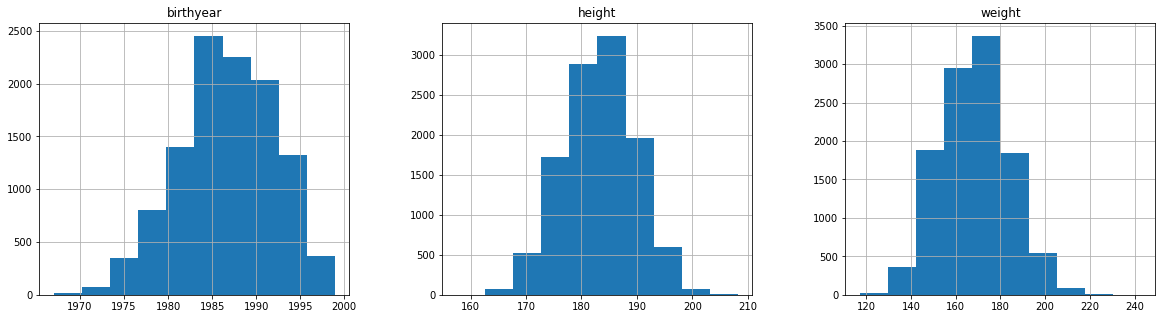

In [43]:
# Visualize the distribution of each variables
player[['birthyear', 'height', 'weight']].hist(figsize = (20, 5), layout = (1, 3))

> Birthyear shows a bit left-skewed distribution which indicates that the young players who were born after 1986 accounts for more percentage than the one of who were born before 1986. Height and weight distributions show normal distributed forms. The average height is 181.9cm and the average weight is 168.4lb.

### Q1. Which player showed the most improved performance throughout his career?

In [44]:
# A1-1. Define a function to measure the difference of max overall average rating and min overall average rating of each player's career
def diff_rating (player_id):
    season_rating = player_merge.query('player_api_id ==  @player_id').groupby('season')['overall_rating'].mean()
    return season_rating.max() - season_rating.min()

# Test function
diff_rating(505942)

4.333333333333329

In [45]:
# A1-2. Get improved performance of all players and append it in player table
player['improve'] = player['player_api_id'].apply(lambda p : diff_rating(p))

player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,birthyear,improve
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,1992,4.333333
1,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,1989,23.375000
2,3,162549,Aaron Doran,186170,1991-05-13,170.18,163,1991,10.200000
3,4,30572,Aaron Galindo,140161,1982-05-08,182.88,198,1982,7.000000
4,5,23780,Aaron Hughes,17725,1979-11-08,182.88,154,1979,8.000000


In [46]:
# A1-3. Sort by improve in descending order
player.sort_values('improve', ascending=False, inplace=True)

player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,birthyear,improve
6715,6725,129944,Marco Reus,188350,1989-05-31,180.34,165,1989,42.000000
3460,3464,41841,Francesco Della Rocca,178043,1987-09-14,182.88,161,1987,39.000000
2835,2838,107417,Eden Hazard,183277,1991-01-07,172.72,163,1991,37.666667
8915,8929,115591,Ricardo Rodriguez,193352,1992-08-25,180.34,170,1992,37.666667
8696,8710,41433,Radja Nainggolan,178518,1988-05-04,175.26,143,1988,37.000000


In [47]:
# A1-4. Average improve of all European league players
player['improve'].mean()

8.455834468828424

### Q2. How is he's rating improved throughout his career? How has his team's standing in the league changed in this period?

In [48]:
# A2-1. Get the season ratings of Marco Reus
player_merge.query('player_api_id ==  129944').groupby('season')['overall_rating'].mean()

season
2006/2007    44.000000
2008/2009    53.500000
2009/2010    71.000000
2010/2011    76.500000
2011/2012    80.500000
2012/2013    84.000000
2013/2014    84.909091
2014/2015    86.000000
2015/2016    86.000000
Name: overall_rating, dtype: float64

> The rating of Marco Reus in 2007/2008 season is missing in the dataset. Let's fill the 2007/2008 season with the mean rating of 2006/2007 season and 2008/2009 season for a better graph.

In [49]:
# A2-2. Fill the 2007/2008 season with the mean rating of 2006/2007 season and 2008/2009 season
reus_rating = player_merge.query('player_api_id ==  129944').groupby('season')['overall_rating'].mean()
reus_rating['2007/2008'] = (reus_rating['2006/2007'] + reus_rating['2008/2009']) / 2

reus_rating.sort_index(inplace=True)
reus_rating

season
2006/2007    44.000000
2007/2008    48.750000
2008/2009    53.500000
2009/2010    71.000000
2010/2011    76.500000
2011/2012    80.500000
2012/2013    84.000000
2013/2014    84.909091
2014/2015    86.000000
2015/2016    86.000000
Name: overall_rating, dtype: float64

> Since the team information of players is not included in the dataset, I searched for Marco Reus' team information of each season in Wikipedia. The result is as follwing:

Season | Team 
--- | --- 
*2006-2007* | Rot Weiss Ahlen II
*2007-2009* | Rot Weiss Ahlen
*2009-2012* | Borussia Mönchengladbach
*2012-* | Borussia Dortmund

> Marco Reus has played in Bundesliga for his whole career. Let's explore how the standing of each team in Bundesliga has changed throughout the years!

In [50]:
# A3-1. What is the ID of Bundesliga?
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [51]:
# A3-2. Check the teams in Bundesliga
bu_match = match_simple.query('league_id == 7809')

home_teams = bu_match['home_team_api_id'].unique()
away_teams = bu_match['away_team_api_id'].unique()

# Check if home teams and away teams are same, empty array means the values are same
np.setdiff1d(home_teams, away_teams)

array([], dtype=int64)

In [52]:
# A3-3. Check the seasons in Bundesliga
bu_season = bu_match['season'].unique()

bu_season

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

In [53]:
home_teams

array([ 9823,  8178, 10189,  8721,  9810,  9912,  8398,  9788,  8295,
        9790,  8697,  8177,  8722,  9911,  9789, 10269,  9904,  8226,
        8358,  8165,  9905,  8350,  8152,  8406,  8357,  8194,  9776,
        8460,  8262,  8234], dtype=int64)

In [54]:
# A3-4. Make a Bundesliga standings table
bu_standings = pd.DataFrame(columns=['season', 'team_id', 'name', 'win', 'draw', 'lose', 'point'])

i = 0
for season in bu_season:
    for team_id in home_teams:
        bu_standings.loc[i] = [season, team_id, team.query('team_api_id == @team_id')['team_long_name'].values[0], 0, 0, 0, 0]
        i = i+1

bu_standings.head()

,season,team_id,name,win,draw,lose,point
0,2008/2009,9823,FC Bayern Munich,0,0,0,0
1,2008/2009,8178,Bayer 04 Leverkusen,0,0,0,0
2,2008/2009,10189,FC Schalke 04,0,0,0,0
3,2008/2009,8721,VfL Wolfsburg,0,0,0,0
4,2008/2009,9810,Eintracht Frankfurt,0,0,0,0


In [55]:
# A3-5. Fill the points in the standings table according to Bundesliga match records
for index, row in bu_match.iterrows():
    each_season = row['season']
    home_team = row['home_team_api_id']
    away_team = row['away_team_api_id']
    home_index = bu_standings.query('season == @each_season').query('team_id == @home_team').index.values[0]
    away_index = bu_standings.query('season == @each_season').query('team_id == @away_team').index.values[0]
    if row['home_team_goal'] > row['away_team_goal']:
        bu_standings.loc[home_index, 'win'] = bu_standings.loc[home_index, 'win'] + 1
        bu_standings.loc[home_index, 'point'] = bu_standings.loc[home_index, 'point'] + 3
        bu_standings.loc[away_index, 'lose'] = bu_standings.loc[away_index, 'lose'] + 1
    elif row['home_team_goal'] == row['away_team_goal']:
        bu_standings.loc[home_index, 'draw'] = bu_standings.loc[home_index, 'draw'] + 1
        bu_standings.loc[home_index, 'point'] = bu_standings.loc[home_index, 'point'] + 1
        bu_standings.loc[away_index, 'draw'] = bu_standings.loc[away_index, 'draw'] + 1
        bu_standings.loc[away_index, 'point'] = bu_standings.loc[away_index, 'point'] + 1
    else:
        bu_standings.loc[home_index, 'lose'] = bu_standings.loc[home_index, 'lose'] + 1
        bu_standings.loc[away_index, 'win'] = bu_standings.loc[away_index, 'win'] + 1
        bu_standings.loc[away_index, 'point'] = bu_standings.loc[away_index, 'point'] + 3
        
bu_standings.sort_values(['season', 'point'], ascending=[True, False], inplace=True)
bu_standings

,season,team_id,name,win,draw,lose,point
3,2008/2009,8721,VfL Wolfsburg,21,6,7,69
0,2008/2009,9823,FC Bayern Munich,20,7,7,67
15,2008/2009,10269,VfB Stuttgart,19,7,8,64
11,2008/2009,8177,Hertha BSC Berlin,19,6,9,63
9,2008/2009,9790,Hamburger SV,19,4,11,61
14,2008/2009,9789,Borussia Dortmund,15,14,5,59
17,2008/2009,8226,TSG 1899 Hoffenheim,15,10,9,55
2,2008/2009,10189,FC Schalke 04,14,8,12,50
1,2008/2009,8178,Bayer 04 Leverkusen,14,7,13,49
10,2008/2009,8697,SV Werder Bremen,12,9,13,45


> The result matches the real standings of Bundesliga of each year! It seems that the match information of teams in second division of Bundesliga are is not applied in the match dataset.

In [56]:
# A3-6. Rank each season by point
bu_standings['rank'] = bu_standings.groupby('season')['point'].rank(ascending=False).astype(int)

bu_standings.head()

,season,team_id,name,win,draw,lose,point,rank
3,2008/2009,8721,VfL Wolfsburg,21,6,7,69,1
0,2008/2009,9823,FC Bayern Munich,20,7,7,67,2
15,2008/2009,10269,VfB Stuttgart,19,7,8,64,3
11,2008/2009,8177,Hertha BSC Berlin,19,6,9,63,4
9,2008/2009,9790,Hamburger SV,19,4,11,61,5


In [57]:
# A3-7. How has the standings of the team where Marco Reus played in changed?
bu_standings.query('name == "Borussia Mönchengladbach"')

,season,team_id,name,win,draw,lose,point,rank
7,2008/2009,9788,Borussia Mönchengladbach,8,7,19,31,15
37,2009/2010,9788,Borussia Mönchengladbach,10,9,15,39,12
67,2010/2011,9788,Borussia Mönchengladbach,10,6,18,36,16
97,2011/2012,9788,Borussia Mönchengladbach,17,9,8,60,4
127,2012/2013,9788,Borussia Mönchengladbach,12,11,11,47,8
157,2013/2014,9788,Borussia Mönchengladbach,16,7,11,55,6
187,2014/2015,9788,Borussia Mönchengladbach,19,9,6,66,3
217,2015/2016,9788,Borussia Mönchengladbach,17,4,13,55,4


In [58]:
bu_standings.query('name == "Borussia Dortmund"')

,season,team_id,name,win,draw,lose,point,rank
14,2008/2009,9789,Borussia Dortmund,15,14,5,59,6
44,2009/2010,9789,Borussia Dortmund,16,9,9,57,5
74,2010/2011,9789,Borussia Dortmund,23,6,5,75,1
104,2011/2012,9789,Borussia Dortmund,25,6,3,81,1
134,2012/2013,9789,Borussia Dortmund,19,9,6,66,2
164,2013/2014,9789,Borussia Dortmund,22,5,7,71,2
194,2014/2015,9789,Borussia Dortmund,13,7,14,46,7
224,2015/2016,9789,Borussia Dortmund,24,6,4,78,2


<a id='conclusions'></a>
## Conclusions

### The player who showed most improved performance in career: `Marco Reus`
> `Marco Reus`' season rating improved total **42** points throughout his career while other players' rating improved **8.5** in average.

[![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Marco_Reus_2014.jpg/200px-Marco_Reus_2014.jpg)](https://en.wikipedia.org/wiki/Marco_Reus)

Season | Team 
--- | --- 
*2006-2007* | Rot Weiss Ahlen II
*2007-2009* | Rot Weiss Ahlen
*2009-2012* | Borussia Mönchengladbach
*2012-* | Borussia Dortmund

### How has the rating of `Marco Reus` changed in his career?

Text(0,0.5,'average rating per season')

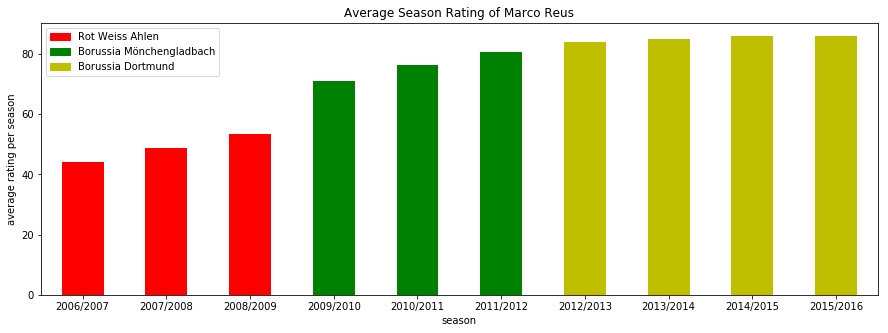

In [59]:
team_color = ['r', 'r', 'r', 'g', 'g', 'g', 'y', 'y', 'y', 'y']
ax = reus_rating.plot(kind="bar", title="Average Season Rating of Marco Reus", color=team_color, figsize=(15,5), rot=0)

# Make a legend
RWA = mpatches.Patch(color='r', label='Rot Weiss Ahlen')
BM = mpatches.Patch(color='g', label='Borussia Mönchengladbach')
BD = mpatches.Patch(color='y', label='Borussia Dortmund')
plt.legend(handles=[RWA, BM, BD,], loc='best')

ax.set_ylabel("average rating per season")

> `Marco Reus`' rating kept improving throughout his career. His rating soared when he started a career in the team *Borussia Mönchengladbach* in the season 2009/2010. Since he moved his team to *Borussia Dortmund*, he has been showing great performance in the matches.

### How has the standings of his teams changed while he is playing in the team?

> Since Rot Weiss Ahlen is not the first division of Bundesliga, there is no information on this team. Therefore, *Borussia Mönchengladbach* and *Borussia Dortmund* Teams' standings are explored.

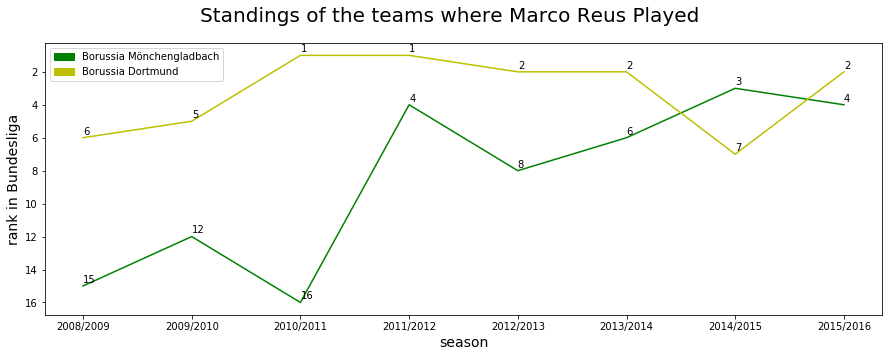

In [60]:
# Add title and labels
fig = plt.figure(figsize=(15,5))
fig.suptitle('Standings of the teams where Marco Reus Played', fontsize = 20)
plt.xlabel('season', fontsize=14)
plt.ylabel('rank in Bundesliga', fontsize=14)

# Plot Borussia Mönchengladbach standings
BM_standings = bu_standings.query('name == "Borussia Mönchengladbach"')
BM_season = BM_standings['season']
BM_rank = BM_standings['rank']
plt.plot(BM_season, BM_rank, color='g')
# Plot Borussia Dortmund standings
BD_standings = bu_standings.query('name == "Borussia Dortmund"')
BD_season = BD_standings['season']
BD_rank = BD_standings['rank']
plt.plot(BD_season, BD_rank, color='y')

# Invert y axis (ranking)
plt.gca().invert_yaxis()

# make a legend
BM = mpatches.Patch(color='g', label='Borussia Mönchengladbach')
BD = mpatches.Patch(color='y', label='Borussia Dortmund')
plt.legend(handles=[BM, BD], loc='best')

# show values on each point
for BM_season, BM_rank in zip(BM_season, BM_rank):
    plt.annotate(str(BM_rank),xy=(BM_season, BM_rank-0.2))
for BD_season, BD_rank in zip(BD_season, BD_rank):
    plt.annotate(str(BD_rank),xy=(BD_season, BD_rank-0.2))

> While `Marco Reus` played in *Borussia Mönchengladbach* (2009-2012), the standings of the team changed 12th -> 16th -> 4th. On the other hand, while he played in *Borussia Dortmund* (2012-), the standings of the team changed 2th -> 2th -> 7th -> 2th. The graph indicates that the single player's rating does not really affect the standings of a team. A soccer team consists of 11 members!

### Limitation

- The rating of `Marco Reus` in season 2007/2008 does not exist. This missing value is filled with the mean value of the rating of the former season and the next season. So, it is not his original rating in this season!
- Each tuple in `player_attributes` is recorded normally from once to third time each season for a player. It means `overall_rating` is not the value measured after each regular game in season. For a better analysis, how often and how the rating is measured should be clarified.